In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils, models, layers
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Build the Dataset

In [2]:
df_train = pd.read_csv("mitbih_train.csv", header=None)
df_test = pd.read_csv("mitbih_test.csv", header=None)

In [3]:
x_trainset = df_train.values[:, :-1]
y_trainset = df_train.values[:, -1].astype(int)
x_testset  = df_test.values[:, :-1]
y_testset  = df_test.values[:, -1].astype(int)
num_classes = 5
y_trainset = keras.utils.to_categorical(y_trainset)
y_testset = keras.utils.to_categorical(y_testset)


In [4]:
print(x_trainset.shape)
print(x_testset.shape)
print(y_trainset.shape)
print(y_testset.shape)

(87554, 187)
(21892, 187)
(87554, 5)
(21892, 5)


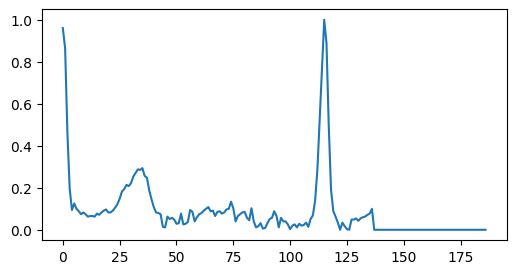

In [5]:
plt.figure(figsize=(6,3))
plt.plot(x_trainset[1])


Data PreProcess Sample

(500,)


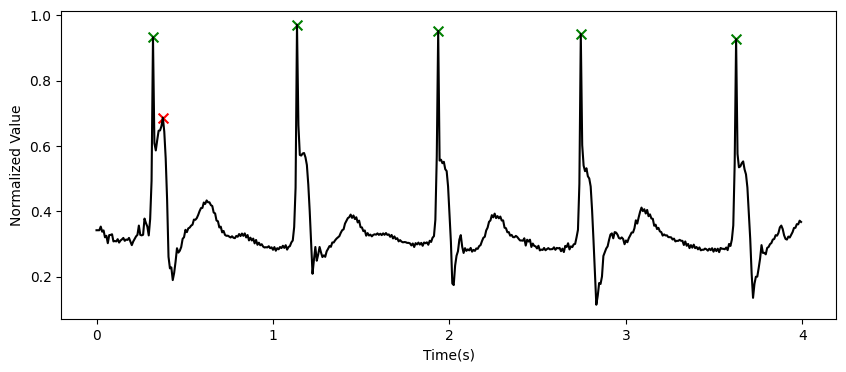

In [36]:
def normalization(data):
    range = np.max(data) - np.min(data)
    return (data-np.min(data)) / range

def getPeak(data):
    ans = []
    i = 0
    threshold = 0.6
    while i<len(data):
        if data[i] > threshold:
            max = 0
            label = i
            while data[i] > threshold:
                if max < data[i]:
                    max = data[i]
                    label = i
                i += 1
            # if len(ans)==0 or label-ans[-1]>25:
            ans.append(label)
            i += 25
        else :
            i += 1
    return ans

def changeFrequence(data):
    ans = np.interp(np.arange(0, len(data), 0.04), np.arange(0, len(data)), data)
    ans = ans[::72]
    return ans
''
testfile = pd.read_csv('MIT-BH/102.csv')
testset = testfile.values[1:, 1]
testset = [float(x) for x in testset]
testset = normalization(testset)
testset = testset[:1440]
testset = changeFrequence(testset)

print(testset.shape)


maxPoints = getPeak(testset)


plt.figure(figsize=(10, 4))
plt.plot(testset, c='black')
plt.xlabel('Time(s)')
plt.ylabel('Normalized Value')
plt.xticks([125*x for x in range(0,5)],[x for x in range(0,5)])
for i in range(0, len(maxPoints)):
    x = maxPoints[i]
    plt.scatter(x, testset[x], s=50, c='green', marker='x')
plt.scatter(47, testset[47], s=50, c='red', marker='x')

Build the Conv1D Model

In [14]:
x_train = x_trainset
x_test = x_testset
values = [i for i in range(len(x_train))]
permutations = np.random.permutation(values)
x_train = x_train[permutations]
y_train = y_trainset[permutations]
y_test = y_testset

In [19]:
convModel = tf.keras.Sequential()
convModel.add(layers.Conv1D(2, kernel_size=5, activation='relu', padding='same', input_shape=(187, 1)))
convModel.add(layers.Flatten())
convModel.add(layers.Dense(num_classes, activation='softmax'))
convModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
history = convModel.fit(x_train, y_train, epochs=50, batch_size=150, validation_data=(x_test, y_test))

Epoch 1/50
584/584 [==============================] - 2s 3ms/step - loss: 0.5221 - accuracy: 0.8535 - val_loss: 0.3821 - val_accuracy: 0.8896
Epoch 2/50
584/584 [==============================] - 1s 2ms/step - loss: 0.3500 - accuracy: 0.8940 - val_loss: 0.3347 - val_accuracy: 0.9009
Epoch 3/50
584/584 [==============================] - 1s 2ms/step - loss: 0.3137 - accuracy: 0.9026 - val_loss: 0.3083 - val_accuracy: 0.9104
Epoch 4/50
584/584 [==============================] - 1s 2ms/step - loss: 0.2887 - accuracy: 0.9132 - val_loss: 0.2880 - val_accuracy: 0.9186
Epoch 5/50
584/584 [==============================] - 1s 2ms/step - loss: 0.2695 - accuracy: 0.9215 - val_loss: 0.2718 - val_accuracy: 0.9210
Epoch 6/50
584/584 [==============================] - 1s 2ms/step - loss: 0.2546 - accuracy: 0.9275 - val_loss: 0.2588 - val_accuracy: 0.9272
Epoch 7/50
584/584 [==============================] - 1s 2ms/step - loss: 0.2427 - accuracy: 0.9320 - val_loss: 0.2477 - val_accuracy: 0.9333
Epoch 

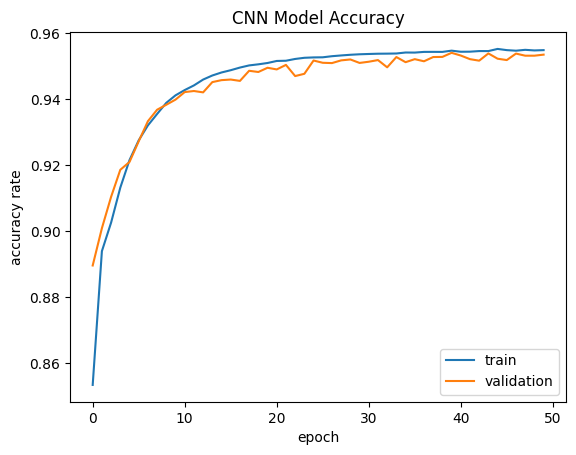

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy rate')
plt.title('CNN Model Accuracy')
plt.legend(['train', 'validation'], loc='lower right')

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(convModel)
tflite_model = converter.convert()

open("./convModel.tflite", "wb").write(tflite_model)
import os
model_size = os.path.getsize("./convModel.tflite")
print("Basic model is %d bytes" % model_size)

Build the MLP Model

In [6]:
x_train = x_trainset
x_test = x_testset
values = [i for i in range(len(x_train))]
permutations = np.random.permutation(values)
x_train = x_train[permutations]
y_train = y_trainset[permutations]
y_test = y_testset

In [7]:
MLPModel = tf.keras.Sequential()
MLPModel.add(layers.Dense(128, activation='relu'))
MLPModel.add(layers.Dense(30, activation='relu'))
MLPModel.add(layers.Dense(num_classes))
MLPModel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])


In [8]:
history = MLPModel.fit(x_train, y_train, epochs=50, batch_size=500, validation_data=(x_test, y_test))

Epoch 1/50
176/176 [==============================] - 1s 2ms/step - loss: 0.4909 - accuracy: 0.8757 - val_loss: 0.2997 - val_accuracy: 0.9194
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 0.2477 - accuracy: 0.9315 - val_loss: 0.2227 - val_accuracy: 0.9383
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 0.1966 - accuracy: 0.9466 - val_loss: 0.1926 - val_accuracy: 0.9486
Epoch 4/50
176/176 [==============================] - 0s 1ms/step - loss: 0.1716 - accuracy: 0.9537 - val_loss: 0.1735 - val_accuracy: 0.9524
Epoch 5/50
176/176 [==============================] - 0s 2ms/step - loss: 0.1560 - accuracy: 0.9579 - val_loss: 0.1548 - val_accuracy: 0.9585
Epoch 6/50
176/176 [==============================] - 0s 2ms/step - loss: 0.1450 - accuracy: 0.9608 - val_loss: 0.1479 - val_accuracy: 0.9608
Epoch 7/50
176/176 [==============================] - 0s 1ms/step - loss: 0.1339 - accuracy: 0.9637 - val_loss: 0.1409 - val_accuracy: 0.9615
Epoch 

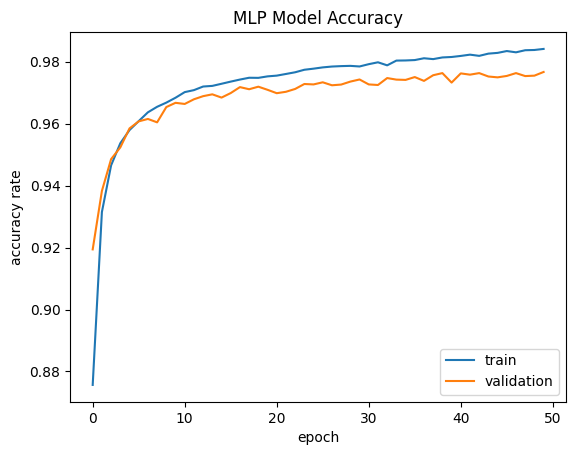

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy rate')
plt.title('MLP Model Accuracy')
plt.legend(['train', 'validation'], loc='lower right')

In [167]:
converter = tf.lite.TFLiteConverter.from_keras_model(MLPModel)
tflite_model = converter.convert()

open("./MLPModel.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\zs\AppData\Local\Temp\tmpwjb3dqpj\assets


INFO:tensorflow:Assets written to: C:\Users\zs\AppData\Local\Temp\tmpwjb3dqpj\assets


114312

Show Different Model's Accuarcy and Size

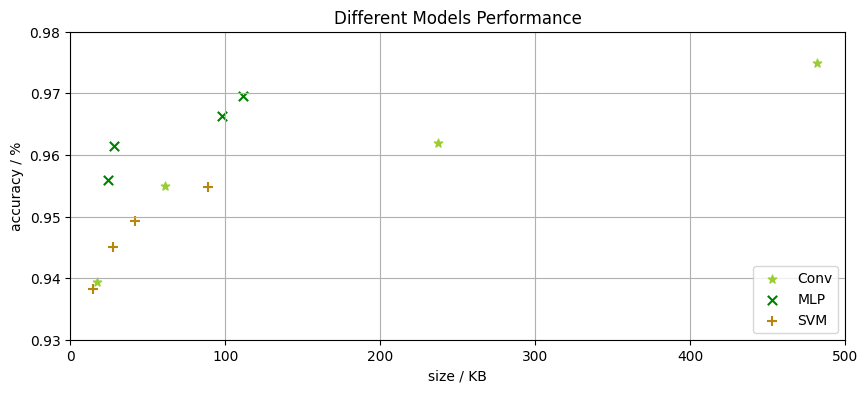

In [249]:
modelSize = [[482.0742, 237.2382, 61.2421, 17.1328], [111.8359, 98.2304, 24.3476, 28.3945], [15.0117, 27.9003, 41.7294, 88.9296]]
finalAccuracy = [[0.9749, 0.9619, 0.9550, 0.9394], [0.9695, 0.9663, 0.9559, 0.9615], [0.9382, 0.9451, 0.9492, 0.9548]]


plt.figure(figsize=(10,4))
plt.title('Different Models Performance')
plt.grid()
plt.xlim(0,500)
plt.ylim(0.93,0.98)
plt.ylabel('accuracy / %')
plt.xlabel('size / KB')
s = 40
plt.scatter(modelSize[0], finalAccuracy[0], s=s, c = 'yellowgreen', marker = '*', label='Conv')
plt.scatter(modelSize[1], finalAccuracy[1], s=s+5, c = 'g', marker = 'x', label='MLP')
plt.scatter(modelSize[2], finalAccuracy[2], s=s+10, c = 'darkgoldenrod', marker = '+', label='SVM')
plt.legend(loc='lower right')

Pruning the Model

In [199]:
import tensorflow_model_optimization as tfmopt
prune_low_magnitude = tfmopt.sparsity.keras.prune_low_magnitude

pruning_params = {
      'pruning_schedule': tfmopt.sparsity.keras.PolynomialDecay(initial_sparsity=0.00,
                                                               final_sparsity=0.50,
                                                               begin_step=0,
                                                               end_step=13460)
}
pruningMLPModel = prune_low_magnitude(MLPModel, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruningMLPModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [200]:
import tempfile

logdir = tempfile.mkdtemp()

callbacks = [
  tfmopt.sparsity.keras.UpdatePruningStep(),
  tfmopt.sparsity.keras.PruningSummaries(log_dir=logdir),
]

pruningMLPModel.fit(x_train, y_train, epochs=50, batch_size=500, validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/50
  1/176 [..............................] - ETA: 2:10 - loss: 0.0137 - accuracy: 0.9940WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_train_batch_end` time: 0.0052s). Check your callbacks.


176/176 [==============================] - 1s 2ms/step - loss: 0.0224 - accuracy: 0.9927 - val_loss: 0.1220 - val_accuracy: 0.9774
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9928 - val_loss: 0.1195 - val_accuracy: 0.9752
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 0.9939 - val_loss: 0.1322 - val_accuracy: 0.9785
Epoch 4/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9937 - val_loss: 0.1249 - val_accuracy: 0.9774
Epoch 5/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.9928 - val_loss: 0.1314 - val_accuracy: 0.9794
Epoch 6/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.9927 - val_loss: 0.1220 - val_accuracy: 0.9794
Epoch 7/50
176/176 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.1227 - val_accuracy: 0.9789
Epoch 8/50
176/17

In [201]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
exportPruningMLPModel = tfmopt.sparsity.keras.strip_pruning(pruningMLPModel)
print_model_weights_sparsity(exportPruningMLPModel)

dense_44/kernel:0: 47.92% sparsity  (11471/23936)
dense_44/bias:0: 0.00% sparsity  (0/128)
dense_45/kernel:0: 47.92% sparsity  (1840/3840)
dense_45/bias:0: 0.00% sparsity  (0/30)
dense_46/kernel:0: 48.00% sparsity  (72/150)
dense_46/bias:0: 0.00% sparsity  (0/5)


In [202]:

converter = tf.lite.TFLiteConverter.from_keras_model(exportPruningMLPModel)
tflite_model = converter.convert()

open("pruningMLPModel.tflite", "wb").write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\zs\AppData\Local\Temp\tmp5tdjsxbb\assets


INFO:tensorflow:Assets written to: C:\Users\zs\AppData\Local\Temp\tmp5tdjsxbb\assets


114312

Quantized

In [203]:
converter = tf.lite.TFLiteConverter.from_keras_model(MLPModel)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_generator():
    for value in x_test:
        yield [np.array(value, dtype=np.float32, ndmin=2)]
converter.representative_dataset = representative_dataset_generator

tflite_model = converter.convert()
open("./MLPModel_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\zs\AppData\Local\Temp\tmpyyuqdap5\assets


INFO:tensorflow:Assets written to: C:\Users\zs\AppData\Local\Temp\tmpyyuqdap5\assets
C:\Users\zs\AppData\Roaming\Python\Python39\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


31240

In [204]:
converter = tf.lite.TFLiteConverter.from_keras_model(exportPruningMLPModel)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_generator():
    for value in x_test:
        yield [np.array(value, dtype=np.float32, ndmin=2)]
converter.representative_dataset = representative_dataset_generator

tflite_model = converter.convert()
open("./pruningMLPModel_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\zs\AppData\Local\Temp\tmpih1b77e9\assets


INFO:tensorflow:Assets written to: C:\Users\zs\AppData\Local\Temp\tmpih1b77e9\assets
C:\Users\zs\AppData\Roaming\Python\Python39\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


31240

In [205]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [206]:
import os
model_size = os.path.getsize("./MLPModel.tflite")
print("MLP model is %d bytes" % model_size)

model_size = os.path.getsize("./pruningMLPModel.tflite")
print("Pruning MLP model is %d bytes" % model_size)

print("Gzipped MLP model: %d bytes" % (get_gzipped_model_size('MLPModel.tflite')))
print("Gzipped pruning MLP model: %d bytes" % (get_gzipped_model_size('pruningMLPModel.tflite')))

model_size = os.path.getsize("./MLPModel_quantized.tflite")
print("Quantized MLP model is %d bytes" % model_size)

model_size = os.path.getsize("./pruningMLPModel_quantized.tflite")
print("Quantized pruning MLP model is %d bytes" % model_size)


print("Gzipped quantized MLP model: %d bytes" % (get_gzipped_model_size('MLPModel_quantized.tflite')))
print("Gzipped quantized pruning MLP model: %d bytes" % (get_gzipped_model_size('pruningMLPModel_quantized.tflite')))

MLP model is 114312 bytes
Pruning MLP model is 114312 bytes
Gzipped MLP model: 105616 bytes
Gzipped pruning MLP model: 66008 bytes
Quantized MLP model is 31240 bytes
Quantized pruning MLP model is 31240 bytes
Gzipped quantized MLP model: 16939 bytes
Gzipped quantized pruning MLP model: 16953 bytes


In [207]:
print(x_testset.shape)
print(y_testset.shape)

(21892, 187)
(21892,)


In [242]:
interpreter = tf.lite.Interpreter(model_path='./MLPModel_quantized.tflite')

interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []
for i in range(0, 21892):
    input = x_testset[i].astype(np.float32)
    input = np.expand_dims(input,axis=0)
    interpreter.set_tensor(input_index, input)
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)
    predictions.append(np.argmax(output))

In [243]:
predictions = np.array(predictions)
acc = (predictions==y_testset).mean()
print(acc)

0.9741914854741458
